# Tutorial 4

## Mean Squared Displacement (MSD)


Molecules in liquds, gases and solids do not stay in the same place and move constantly. Think about a drop of dye in a glass of water, as time passes the dye distributes throughout the water. This process is called diffusion and is common throughout nature and an incredibly relevant property for materials scientists who work on things like batteries.  

Using the dye as an example, the motion of a dye molecule is not simple. As it moves it is jostled by collisions with other molecules, preventing it from moving in a straight path. If the path is examined in close detail, it will be seen to be a good approximation to a random walk. In mathmatics a random walk is a series of steps, each taken in a random direction. This was analysed by Albert Einstein in a study of Brownian motion and he showed that the mean square of the distance travelled by a particle following a random walk is proportional to the time elapsed. 

\begin{align}
\Big \langle r_{i}^{2} \big \rangle & = 6 D_t + C 
\end{align}


where 

\begin{align}
\Big \langle r_{i}^{2} \big \rangle = \frac{1}{3} \Big< | r_{i}(t) - r_{i}(0) |^2 \Big>.
\end{align}


where $\Big \langle r^2 \big \rangle$ is the mean squared distance, t is time, $D_t$ is the diffusion rate and C is a constant. If $\Big \langle r_{i}^{2} \big \rangle$ is plotted as a function of time, the gradient of the curve obtained is equal to 6 times the self-diffusion coefficient of particle i. 
The state of the matter effects the shape of the MSD plot, solids, where little to no diffusion is occuring, has a flat MSD profile. In a liquid however, the particles diffusion randomly and the gradient of the curve is proportional to the diffusion coefficient. 

## What is the mean squared displacement

Going back to the example of the dye in water, lets assume for the sake of simplicity that we are in one dimension. Each step can either be forwards or backwards and we cannot predict which. From a given starting position, what distance is our dye molecule likely to travel after 1000 steps? This can be determined simply by adding together the steps, taking into account the fact that steps backwards subtract from the total, while steps forward add to the total. Since both forward and backward steps are equally probable, we come to the surprising conclusion that the probable distance travelled sums up to zero.

By adding the square of the distance we will always be adding positive numbers to our total which now increases linearly with time. Based upon equation 1 it should now be clear that a plot of $\Big \langle r_{i}^{2} \big \rangle$ vs time with produce a line, the gradient of which is equal to 6D. Giving us direct access to the diffusion coefficient of the system. 

In [1]:
from polypy import read as rd
from polypy.msd import MSD 
from polypy.msd import RegionalMSD 
from polypy import analysis
from polypy import utils as ut
from polypy import plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

This example will use a short (50,000 steps), pre-prepared trajectory of bulk $CaF_2$. In reality we probably want a considerably longer simulation (~10,000,000 steps). Such simulations generate huge files (5GB) and the analysis would take too long for this tutorial. 

The first step is to read the history file to generate the data. The `HISTORY` class expects two things, the filename of the history file and a list of atoms to read. It will return a `polypy.read.Trajectory` object, which stores the the atom labels (`Trajectory.atom_labels`), datatype (`Trajectory.data_type`), cartesian coordinates (`Trajectory.cartesian_coordinates`), fractiona coordinates (`Trajectory.fractional_coordinates`), reciprocal lattice vectors (`Trajectory.reciprocal_lv`), lattice vectors (`Trajectory.lv`) cell lengths (`Trajectory.cell_lengths`), total atoms in the file (`Trajectory.atoms_in_history`), timesteps (`Trajectory.timesteps`), total atoms per timestep (`Trajectory.total_atoms`).

In [2]:
history = rd.History("../example_data/HISTORY", ["F"])

Once the data has been read into the code the MSD calculation can be performed. The msd function requires the data and the time between records which in this case is 0.1ps. The msd function will then return a dictionary containing the time, 3D MSD and the directional components. 

In [3]:
f_msd = MSD(history.trajectory, sweeps=2)

output = f_msd.msd()

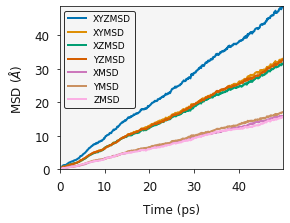

In [4]:
ax = plotting.msd_plot(output)
plt.show()

In [5]:
print("Three Dimensional Diffusion Coefficient", output.xyz_diffusion_coefficient())
print("One Dimensional Diffusion Coefficient in X", output.x_diffusion_coefficient())
print("One Dimensional Diffusion Coefficient in Y", output.y_diffusion_coefficient())
print("One Dimensional Diffusion Coefficient in Z", output.z_diffusion_coefficient())

Three Dimensional Diffusion Coefficient 1.6065821816861137
One Dimensional Diffusion Coefficient in X 1.5900343655685854
One Dimensional Diffusion Coefficient in Y 1.7007108053999864
One Dimensional Diffusion Coefficient in Z 1.5290013740897677


## Arrhenius


It is then possible to take diffusion coefficients, calculated over a large temperature range and, using the Arrhenius equation calculate the activation energy for diffusion. Common sense and chemical intuition suggest that the higher the temperature, the faster a given chemical reaction will proceed. Quantitatively this relationship between the rate a reaction proceeds and its temperature is determined by the Arrhenius Equation. At higher temperatures, the probability that two molecules will collide is higher. This higher collision rate results in a higher kinetic energy, which has an effect on the activation energy of the reaction. The activation energy is the amount of energy required to ensure that a reaction happens.  
  
\begin{align}
k = A * e^{(-Ea / RT)}
\end{align}
  
where k is the rate coefficient, A is a constant, Ea is the activation energy, R is the universal gas constant, and T is the temperature (in kelvin).



## Ionic Conductivity

Usefully, as we have the diffusion coefficient, the number of particles (charge carriers) and the ability to calculate the volume, we can convert this data into the ionic conductivity and then the resistance. 

\begin{align}
\sigma & = \frac{D C_F e^2}{k_B T} 
\end{align}

where $\sigma$ is the ionic conductivity, D is the diffusion coefficient, $C_F$ is the concentration of charge carriers, which in this case if F ions, $e^2$ is the charge of the diffusing species, $k_B$ is the Boltzmann constant and T is the temperature. 

The resitance can then be calculated according to 

\begin{align}
\Omega & = \frac{1}{\sigma} 
\end{align}

So the first step is to calculate the volume, the system voume module will do this from the given data. 

In [6]:
volume, step = analysis.system_volume(history.trajectory)
average_volume = np.mean(volume[:50])

The number of charge carriers is just the total number of atoms.

In [8]:
sigma = analysis.conductivity(history.trajectory.total_atoms, 
                        average_volume, 
                        output.xyz_diffusion_coefficient(), 
                        1500)

In [10]:
print("Ionic Conductivity :", sigma)

Ionic Conductivity : 0.0008745917087252474


In [11]:
print("Resistivity :", (1 / sigma)) 

Resistivity : 1143.3906702106062


## Simulation Length

It is important to consider the lenght of your simulation (Number of steps). The above examples use a short trajectory but it is at a sufficient temperature that there are enough diffusion events to get a good MSD plot. The following example is of a very short simulation, you will hopefully note that the MSD plot is clearly not converged. 

In [13]:
data_short = rd.History("../example_data/HISTORY_short", atom_list=["F"])

In [16]:
f_msd_short = MSD(data_short.trajectory, sweeps=2)

output = f_msd_short.msd()

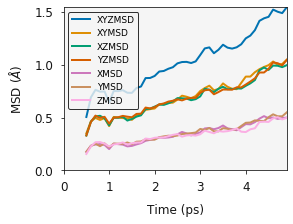

In [17]:
ax = plotting.msd_plot(output)
plt.show()

## State of Matter

It is possible to identify the phase of matter from the MSD plot.

<center>
    <br>
    <img src="./figures/fig001.png" width="400px">
    <i>Figure 1. The anticipated MSD form for each state of matter.</i>
    <br>
</center>

The Fluorine diffusion discussed already clearly shows that the fluorine sub lattice has melted and the diffusion is liquid like. Whereas, carrying out the same analysis on the Calcium sub lattice shows that while the fluorine sub lattice has melted, the Calcium sub lattice is still behaving like a solid. 




## Regional MSD Calculations

Often in solid state chemistry simulations involve defects, both structural e.g. grain boundaries, dislocations and surface, and chemical e.g. point defects. It is important to try and isolate the contributions of these defects to the overall properties. Regarding diffusion, it could be imagined that a certain region within a structure will have different properties compared with the stoichiometric bulk, e.g. a grain boundary vs the grains, or the surface vs the bulk. `polypy` has the capability to isolate trajectories that pass within certain regions of a structure and thus calculate a diffusion coefficient for those regions. 

In [19]:
data_short = rd.History("../example_data/HISTORY", atom_list=["F"])

In [20]:
f_msd = RegionalMSD(history.trajectory, -5, 5, 0.1)
output = f_msd.analyse_trajectory()

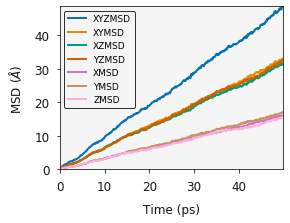

In [21]:
ax = plotting.msd_plot(output)
plt.show()

In [22]:
print(output.xyz_diffusion_coefficient())

1.6005368498765318
